# **Dataproc**

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
!pip install colab-env --upgrade

In [6]:
import colab_env
colab_env.envvar_handler.add_env("GOOGLE_PROJECT_ID", "dogwood-mission-408515", overwrite=True) # prefab-bruin-402414 , spring-cab-402321
colab_env.envvar_handler.add_env("BUCKET_NAME", "fnc_bucket_final", overwrite=True) # prova2 , final

Mounted at /content/gdrive


In [7]:
# Import global variables from Google Drive
import colab_env
!more gdrive/My\ Drive/vars.env

COLAB_ENV = Active
GOOGLE_PROJECT_ID = dogwood-mission-408515
BUCKET_NAME = fnc_bucket_final


In [8]:
# Google Cloud auth
import os
from google.colab import auth
auth.authenticate_user()

project_id = os.getenv("GOOGLE_PROJECT_ID")
!gcloud config set project {project_id}

Updated property [core/project].


In [9]:
import os
# Create project bucket
BUCKET_NAME = os.getenv("BUCKET_NAME")
print(BUCKET_NAME)

fnc_bucket_final


In [10]:
# Sync colab bucket directory with project bucket
!gsutil -m rsync -r gs://{BUCKET_NAME}/data/analysis/ /content/gdrive/MyDrive/bucket


both the source and destination. Your crcmod installation isn't using the
module's C extension, so checksumming will run very slowly. If this is your
first rsync since updating gsutil, this rsync can take significantly longer than
usual. For help installing the extension, please see "gsutil help crcmod".

Building synchronization state...
Starting synchronization...
Copying gs://fnc_bucket_final/data/analysis/instances1cores3/result50.json...
Copying gs://fnc_bucket_final/data/analysis/instances12cores1/result100.json...
Copying gs://fnc_bucket_final/data/analysis/instances2cores3/result250.json...
Copying gs://fnc_bucket_final/data/analysis/instances2cores3/result500.json...
Copying gs://fnc_bucket_final/data/analysis/instances1cores2/result100.json...
Copying gs://fnc_bucket_final/data/analysis/instances3cores1/result100.json...
Copying gs://fnc_bucket_final/data/analysis/instances1cores3/result100.json...
Copying gs://fnc_bucket_final/data/analysis/instances3cores1/result250.json..

In [ ]:
!gsutil -m rsync -r /content/gdrive/MyDrive/bucket/analysis/ gs://{BUCKET_NAME}/data/analysis/


both the source and destination. Your crcmod installation isn't using the
module's C extension, so checksumming will run very slowly. If this is your
first rsync since updating gsutil, this rsync can take significantly longer than
usual. For help installing the extension, please see "gsutil help crcmod".

Building synchronization state...
Starting synchronization...


## **Create a GCS Bucket**

In [ ]:
REGION="us-central1"
#BUCKET_NAME="fake-news-classification-bucket-prova"

#!gsutil mb -c standard -l us-central1 gs://${BUCKET_NAME}
!gsutil mb -l us-central1 -b on -p {project_id} gs://{BUCKET_NAME}

Creating gs://fnc-bucket-final/...
ServiceException: 409 A Cloud Storage bucket named 'fnc-bucket-final' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


## **Create a Cluster**

In [11]:
REGION="us-central1"
ZONE="us-central1-a"
CLUSTER_NAME="spark-jupyter"
PROJECT_NAME="Fake-News-Classification"

# **Execution Loop**

In [14]:
import time
import subprocess
import json

jobs_times = []
real_times = []

n_columns = 50 # 100 250
min_number_worker = 1
max_number_worker = 1
worker_numbers_list = [n_worker for n_worker in range(min_number_worker, max_number_worker + 1)]
print(worker_numbers_list)

old = -1
n_cores = -1

def getClusterProperties():
  cpu_vcores = None
  memory = None

  try:
    # Run gcloud command and capture the output
    #!gcloud dataproc clusters describe {CLUSTER_NAME} --region={REGION}
    command = f"gcloud dataproc clusters describe {CLUSTER_NAME} --region={REGION} --format=json"
    process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    output, _ = process.communicate()

    # Check if the command was successful
    if process.returncode == 0 :
      # Parse JSON output
      cluster_info = json.loads(output.decode('utf-8'))

      print(cluster_info)
      # Access specific properties
      cpu_vcores = int(cluster_info.get("config", {}).get("softwareConfig", {}).get("properties", {}).get("yarn:yarn.nodemanager.resource.cpu-vcores"))
      memory = int(cluster_info.get("config", {}).get("softwareConfig", {}).get("properties", {}).get("yarn:yarn.nodemanager.resource.memory-mb"))

      # Output the desired information
      print(f"CPU VCORES: {cpu_vcores}")
      # Output the desired information
      print(f"MEMORY: {memory}")
    else :
      # Handle command failure
      print("Error: Unable to retrieve cluster information.")
  except Exception as e :
    print(f"Error: {e}")

  return memory, cpu_vcores

def createProperties(n_worker, n_cores, memory, cpu_vcores) :
  # spark.sql.adaptive.enabled=false,
  properties = "spark.dynamicAllocation.enabled=true,spark.serializer=org.apache.spark.serializer.KryoSerializer,spark.executor.extraJavaOptions=-XX:+UseG1GC"

  if cpu_vcores is not None and memory is not None :
    if n_worker == 1 and n_cores == 1 :
      executor_cores = n_cores
      executor_per_node = int(n_cores // executor_cores)
      possible = max(384, int((((memory - 1024) // executor_per_node) // 1.1) * 0.1))
      print(possible)
      if possible == 384 :
        executor_memory = int(((((memory - 1024) - (384 * executor_per_node)) // executor_per_node) // 1.1))
      else :
        executor_memory = int((((memory - 1024) // executor_per_node) // 1.1))
      executor_instances = 1
      driver_cores = executor_cores
      driver_memory = executor_memory
      shuffle_partitions = n_cores
      parallelism = n_cores

      properties = properties + ",spark.master=local[1]"

    else :
      executor_cores = cpu_vcores - 1
      executor_per_node = int((cpu_vcores - 1) // executor_cores)
      print("executor_per_node: " + str(executor_per_node))
      executor_instances = (executor_per_node * n_worker)
      print("memory: " + str(memory))
      print("memory: " + str(memory - 1024))
      possible = max(384, int((((memory - 1024) // executor_per_node) // 1.1) * 0.1))
      print(possible)
      if possible == 384 :
        executor_memory = int(((((memory - 1024) - (384 * executor_per_node)) // executor_per_node)))
      else :
        executor_memory = int((((memory - 1024) // executor_per_node) // 1.1))
      print("executor memory: " + str(executor_memory))
      driver_cores = executor_cores
      driver_memory = executor_memory
      partitions = (executor_instances * executor_cores) * 1
      parallelism = partitions
      shuffle_partitions = partitions


    properties = properties + f",spark.executor.cores={executor_cores},spark.driver.cores={driver_cores},spark.executor.memory={executor_memory}m,spark.driver.memory={driver_memory}m,spark.executor.instances={executor_instances},spark.sql.shuffle.partitions={shuffle_partitions},spark.default.parallelism={parallelism}"

  return properties, executor_instances, executor_cores


def createCluster(n_worker) :
  if n_worker == 1 :
    !gcloud dataproc clusters create {CLUSTER_NAME} \
      --enable-component-gateway \
      --bucket={BUCKET_NAME} \
      --region={REGION} \
      --single-node \
      --master-machine-type n1-standard-4 \
      --master-boot-disk-type pd-ssd \
      --master-boot-disk-size 64 \
      --project={project_id} \
      --initialization-actions=gs://{BUCKET_NAME}/initialization.sh \
      --properties="capacity-scheduler:yarn.scheduler.capacity.resource-calculator=org.apache.hadoop.yarn.util.resource.DominantResourceCalculator"

  else :
    !gcloud dataproc clusters create {CLUSTER_NAME} \
      --enable-component-gateway \
      --bucket={BUCKET_NAME} \
      --region={REGION} \
      --master-machine-type n1-standard-4 \
      --master-boot-disk-type pd-ssd \
      --master-boot-disk-size 64 \
      --num-workers={n_worker} \
      --worker-machine-type n1-standard-4 \
      --worker-boot-disk-size 64 \
      --project={project_id} \
      --initialization-actions=gs://{BUCKET_NAME}/initialization.sh \
      --properties="capacity-scheduler:yarn.scheduler.capacity.resource-calculator=org.apache.hadoop.yarn.util.resource.DominantResourceCalculator"


try :
  for n_worker in worker_numbers_list :

    num_worker = n_worker
    if n_worker == 0 :
      n_cores = 1
    else :
      n_cores = 3

    if n_worker == 0 :
      n_worker = 1

    if old == -1 :
      createCluster(n_worker)

    else :
      if old == 1 or n_worker == 1 :
        if not (old == 1 and n_worker == 1) :
          # Delete cluster
          !gcloud dataproc clusters delete {CLUSTER_NAME} --region={REGION} --quiet

          createCluster(n_worker)

      else :
        # Update cluster
        !gcloud dataproc clusters update {CLUSTER_NAME} \
          --region={REGION} \
          --num-workers={n_worker}


    memory, cpu_vcores = getClusterProperties()

    properties, instances, cores = createProperties(n_worker, n_cores, memory, cpu_vcores)

    print(properties)

    folder_result = "analysis/"
    if n_worker == 1 and n_cores == 1 :
      folder_result += f"sequential/result{n_columns}"
      mode = False
    else :
      folder_result += f"instances{instances}cores{cores}/result{n_columns}"
      mode = True

    print(folder_result)
    dataset_folder = f"dataset_final{n_columns}.csv"

    vocab_size = 500

    start_real_time = time.time() * 1000
    # Run job
    !gcloud dataproc jobs submit spark \
      --region={REGION} \
      --cluster={CLUSTER_NAME} \
      --class=MainApp \
      --jars=gs://{BUCKET_NAME}/jar/FakeNewsClassificationWithDecisionTreeMR.jar \
      --properties={properties} \
      -- gs://{BUCKET_NAME} {dataset_folder} {vocab_size} {folder_result}

    time_job = round((time.time() * 1000) - start_real_time)
    jobs_times.append(time_job)

    print("Job time: " + str(time_job) + "ms")

    !gsutil -m rsync -r gs://{BUCKET_NAME}/data/analysis /content/gdrive/MyDrive/bucket/analysis

    with open(f"/content/gdrive/MyDrive/bucket/{folder_result}.json", "r") as fid :
      data = json.load(fid)
      data['Job Time'] = time_job

    with open(f"/content/gdrive/MyDrive/bucket/{folder_result}.json", 'w') as file:
      json.dump(data, file)

    !gsutil -m rsync -r /content/gdrive/MyDrive/bucket/analysis gs://{BUCKET_NAME}/data/analysis

    old = n_worker

  print("All jobs times: " + str(jobs_times))

  # !gsutil -m rsync -r gs://{BUCKET_NAME}/data/analysis /content/gdrive/MyDrive/bucket

finally :
  # Delete cluster
  !gcloud dataproc clusters delete {CLUSTER_NAME} --region={REGION} --quiet

[1]
Waiting on operation [projects/dogwood-mission-408515/regions/us-central1/operations/f9645329-7ed0-37e5-91f6-260ae1e11541].

Created [https://dataproc.googleapis.com/v1/projects/dogwood-mission-408515/regions/us-central1/clusters/spark-jupyter] Cluster placed in zone [us-central1-c].
{'clusterName': 'spark-jupyter', 'clusterUuid': 'a1429171-88d3-4996-890b-60a6c6433ec8', 'config': {'configBucket': 'fnc_bucket_final', 'endpointConfig': {'enableHttpPortAccess': True, 'httpPorts': {'HDFS NameNode': 'https://sdlebdi65rfgzdmrddcvfj6pru-dot-us-central1.dataproc.googleusercontent.com/hdfs/dfshealth.html', 'HiveServer2 (spark-jupyter-m)': 'https://sdlebdi65rfgzdmrddcvfj6pru-dot-us-central1.dataproc.googleusercontent.com/hiveserver2ui/spark-jupyter-m?host=spark-jupyter-m', 'MapReduce Job History': 'https://sdlebdi65rfgzdmrddcvfj6pru-dot-us-central1.dataproc.googleusercontent.com/jobhistory/', 'Spark History Server': 'https://sdlebdi65rfgzdmrddcvfj6pru-dot-us-central1.dataproc.googleuserconte

In [88]:
from json.encoder import JSONEncoder
import matplotlib.pyplot as plt
import json
import re
import os

test_dict = {1:[2,3], 2:[2,3], 3:[1,2,3], 4:[2,3], 6:[1], 9:[1], 12:[1]}

pattern = re.compile(r'(\d+)')
info_dict = {}

for n_istances in test_dict.keys():

    n_cores = test_dict.get(n_istances)

    for core in n_cores:
        # Read execution time
        path_dir = "/content/gdrive/MyDrive/bucket/analysis/instances{}cores{}".format(n_istances, core)

        list_json = os.listdir(path_dir)

        for json_file in list_json:

            with open(os.path.join(path_dir,json_file), 'r') as fid:

              json_loaded = json.load(fid)

              jobs_time = json_loaded["Job Time"]

              ds_col_n = int(pattern.search(json_file).group(1))

              info_dict[n_istances, core, ds_col_n] = json_loaded


path_dir = "/content/gdrive/MyDrive/bucket/analysis/sequential"

list_json = os.listdir(path_dir)

for json_file in list_json:

  with open(os.path.join(path_dir,json_file), 'r') as fid:

    json_loaded = json.load(fid)

    jobs_time = json_loaded["Job Time"]

    ds_col_n = int(pattern.search(json_file).group(1))

    info_dict[0, 0, ds_col_n] = json_loaded



In [89]:
keys_100 = [key for key in info_dict.keys() if key[2] == 100]
keys_250 = [key for key in info_dict.keys() if key[2] == 250]
keys_500 = [key for key in info_dict.keys() if key[2] == 500]

print(keys_100)
print(keys_250)
print(keys_500)

[(1, 3, 100), (2, 2, 100), (2, 3, 100), (3, 1, 100), (3, 2, 100), (3, 3, 100), (4, 2, 100), (4, 3, 100), (6, 1, 100), (9, 1, 100), (12, 1, 100), (0, 0, 100)]
[(1, 2, 250), (2, 2, 250), (2, 3, 250), (3, 1, 250), (3, 2, 250), (3, 3, 250), (4, 2, 250), (4, 3, 250), (6, 1, 250), (9, 1, 250), (12, 1, 250), (0, 0, 250)]
[(2, 3, 500), (3, 3, 500), (4, 3, 500)]


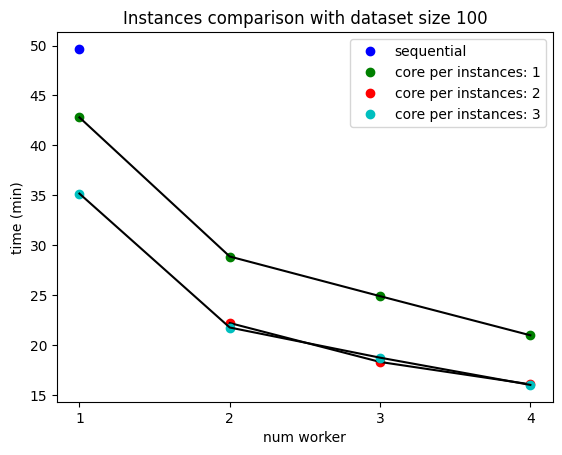

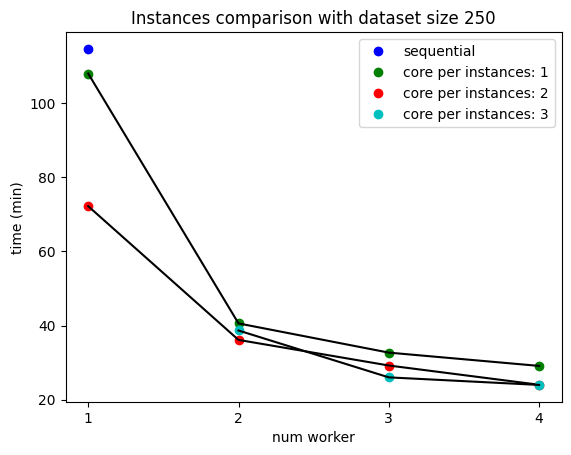

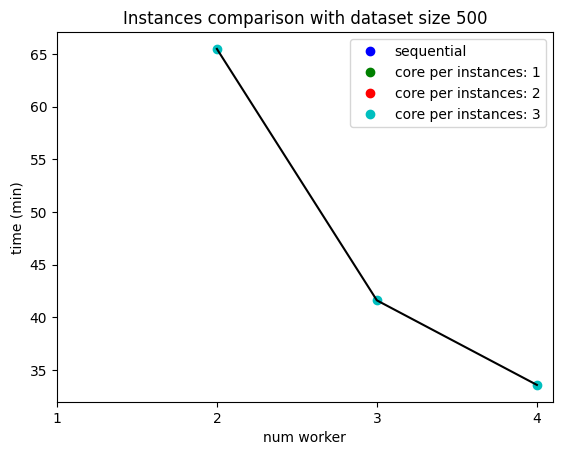

In [90]:
# Plot results
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

colors = ['bo','go','ro','co']

for ds_size, key_list in [(100,keys_100), (250,keys_250), (500,keys_500)]:

  cores_list = {0:list(), 1: list(), 2: list(), 3: list()}
  jobs_times = {0:list(), 1: list(), 2: list(), 3: list()}

  for keys in key_list:

    infos = info_dict[keys]

    if keys[1] == 2:
      cores_list[keys[1]].append(ceil((keys[0] * keys[1]) / 2))
    elif keys[1] == 0:
      cores_list[keys[1]].append(1)
    else:
      cores_list[keys[1]].append(ceil((keys[0] * keys[1]) / 3))

    jobs_times[keys[1]].append(round(infos["Job Time"] / 60000, 2))


  for key in cores_list.keys():

    if key == 0:
      label='sequential'
    else:
      label=f'core per instances: {key}'
    plt.plot(cores_list[key], jobs_times[key], colors[key], label=label)
    plt.plot(cores_list[key], jobs_times[key], 'k')

  plt.xticks([1,2,3,4])
  plt.ylabel('time (min)')
  plt.xlabel('num worker')
  plt.title(f'Instances comparison with dataset size {ds_size}')
  plt.legend()
  plt.show()

In [ ]:
keys_3cores = [key for key in info_dict.keys() if key[1] == 3 and key[2] != 50]


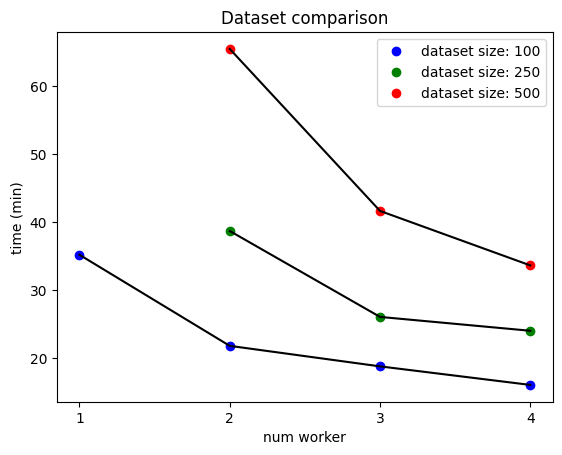

In [83]:
# Plot results
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

colors = ['bo','go','ro']

worker_list = {100:list(), 250: list(), 500: list()}
jobs_times = {100:list(), 250: list(), 500: list()}

for keys in keys_3cores:

    infos = info_dict[keys]

    if keys[1] == 2:
      worker_list[keys[2]].append(ceil((keys[0] * keys[1]) / 2))
    elif keys[1] == 0:
      worker_list[keys[2]].append(0)
    else:
      worker_list[keys[2]].append(ceil((keys[0] * keys[1]) / 3))

    jobs_times[keys[2]].append(round(infos["Job Time"] / 60000, 2))

for i,key in enumerate(worker_list.keys()):

  if key == 0:
    label='sequential'
  else:
    label=f'dataset size: {key}'
  plt.plot(worker_list[key], jobs_times[key], colors[i], label=label)
  plt.plot(worker_list[key], jobs_times[key], 'k')

plt.xticks([1,2,3,4])
plt.ylabel('time (min)')
plt.xlabel('num worker')
plt.title(f'Dataset comparison')
plt.legend()
plt.show()

In [84]:
keys_dataset_comparison = [(0,0,25),(1,3,50),(2,3,100),(4,3,250)]

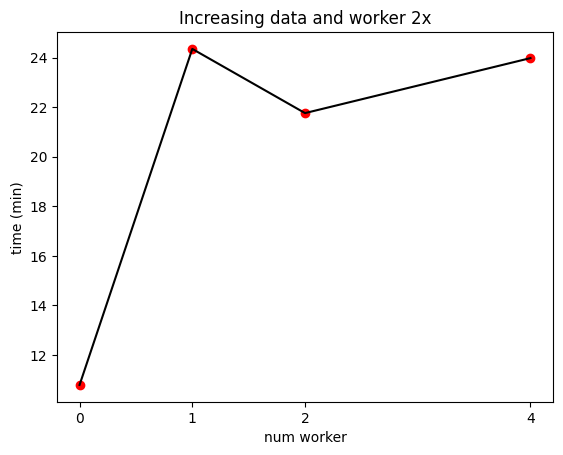

In [85]:
# Plot results
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

worker_list = []
jobs_times = []

for keys in keys_dataset_comparison:

    infos = info_dict[keys]

    if keys[1] == 2:
      worker_list.append(ceil((keys[0] * keys[1]) / 2))
    elif keys[1] == 0:
      worker_list.append(keys[1])
    else:
      worker_list.append(ceil((keys[0] * keys[1]) / 3))

    jobs_times.append(round(infos["Job Time"] / 60000, 2))


plt.plot(worker_list, jobs_times, 'ro')
plt.plot(worker_list, jobs_times, 'k')

plt.xticks([0,1,2,4])
plt.ylabel('time (min)')
plt.xlabel('num worker')
plt.title(f'Increasing data and worker 2x')
plt.show()